# Dynamics Analysis

BrainPy provides fundamental methods for dynamics analysis of neuron models, including:

- (1) phase plane analysis for 1-dimensional and 2-dimensional systems;
- (2) codimension 1 and codimension 2 bifurcation analysis.

We take FitzHugh-Nagumo model as example to demonstrate how to perform dynamics analysis with BrainPy API.

The model is given by:

$$ \frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} $$

$$ \tau \frac {dw} {dt} = V + a - b w $$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

Let's start by defining the model.

In [1]:
import brainpy as bp
import numpy as np

bp.profile.set(dt=0.02, numerical_method='rk4')


def get_FNmodel(a=0.7, b=0.8, tau=12.5, Vth=1.9):
    state = bp.types.NeuState({'v': 0., 'w': 1., 'spike': 0., 'input': 0.})

    @bp.integrate
    def int_w(w, t, v):
        return (v + a - b * w) / tau

    @bp.integrate
    def int_v(v, t, w, Iext):
        return v - v * v * v / 3 - w + Iext

    def update(ST, _t):
        ST['w'] = int_w(ST['w'], _t, ST['v'])
        v = int_v(ST['v'], _t, ST['w'], ST['input'])
        ST['spike'] = np.logical_and(v >= Vth, ST['v'] < Vth)
        ST['v'] = v
        ST['input'] = 0.

    return bp.NeuType(name='FitzHugh_Nagumo',
                      ST=state,
                      steps=update)

## Phase Plane Analysis

We provide ``brainpy.PhasePortraitAnalyzer`` to support phase plane analysis for 1-dimensional and 2-dimensional dynamical systems. 

Two parameters should be specified to initialize a ``PhasePortraitAnalyzer``:

- ``model``: The neuron model to be analysis.
- ``target_vars``: The variables to be analysis and its value range.

And two parameters are optional:

- ``fixed_vars``: The slow variables to be fixed as stational variables (Optional for higher order system).
- ``pars_update``: Parameters to update.


After defining a ``PhasePortraitAnalyzer``, you can call the following functions:

- ``plot_nullcline()``: Plot the nullclines.
- ``plot_vector_field()``: Plot the vector field.
- ``plot_fixed_point()``: Find and plot the fixed points, and perform stability analysis (print to the terminal).
- ``plot_trajectory()``: Plot trajectories according to the settings (initial var1, initial var2, duration).

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

Fixed point #1 at v=-0.2729009589972752, w=0.5338738012534059 is a unstable-node.


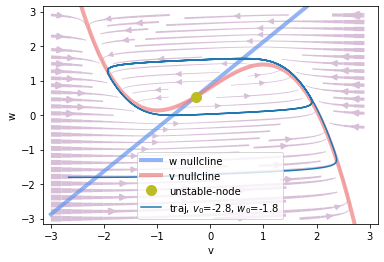

In [2]:
neuron = get_FNmodel(a=0.7, b=0.8, tau=12.5)

analyzer = bp.PhasePortraitAnalyzer(
    model=neuron,
    target_vars={'v': [-3, 3], 'w': [-3., 3.]},
    fixed_vars={'Iext': 0.8})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([(-2.8, -1.8, 100.)],
                         inputs=('ST.input', 0.8),
                         show=True)

We can see an unstable-node at the point (v=-0.27, w=0.53) inside a limit cycle. Then we can run a simulation with the same parameters and initial values to see the periodic activity that correspond to the limit cycle.

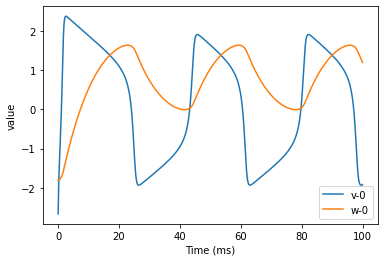

In [3]:
group = bp.NeuGroup(neuron, 1, monitors=['v', 'w'])
group.ST['v'] = -2.8
group.ST['w'] = -1.8
group.run(100., inputs=('ST.input', 0.8)) 
bp.visualize.line_plot(group.mon.ts, group.mon.v, legend='v', ) 
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

## Bifurcation Analysis

We provide ``brainpy.BifurcationAnalyzer`` for users to perform bifucation analysis.

The ``PhasePortraitAnalyzer`` receives the following parameters:

- ``model``: The neuron model to be analysis.
- ``target_pars``: The parameters to be change and the ranges.
- ``dynamical_vars``: The variables of the system and the change ranges.
- ``par_resolution``: The numerical resolution of the bifurcation analysis.

### Codimension 1 bifurcation analysis

We will first see the codimension 1 bifurcation anlysis of the model. For example, we vary the input $I_{ext}$ between 0 to 1 and see how the system change it's stability.

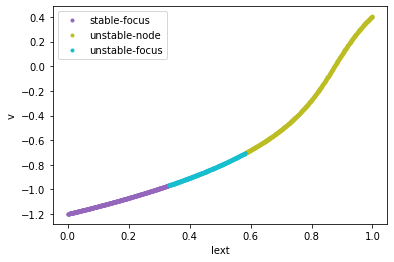

In [4]:
analyzer = bp.BifurcationAnalyzer(
    model=neuron,
    target_pars={'Iext': [0., 1.]},
    dynamical_vars={'v': [-3, 3], 'w': [-3., 3.]},
    par_resolution=0.001,
)
analyzer.plot_bifurcation(plot_vars=['v'], show=True)

### Codimension 2 bifurcation analysis

We simulaneously change $I_{ext}$ and parameter $a$.

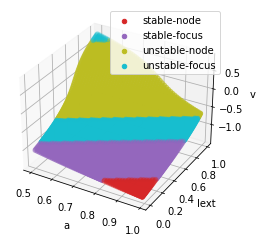

In [5]:
analyzer = bp.BifurcationAnalyzer(
    model=neuron,
    target_pars={'a': [0.5, 1.], 'Iext': [0., 1.]},
    dynamical_vars={'v': [-3, 3], 'w': [-3., 3.]},
    par_resolution=0.01,
)
analyzer.plot_bifurcation(plot_vars=['v'], show=True)